In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from collections import defaultdict 
from scipy.stats import zscore


## Data Processing

In [2]:
df = pd.read_csv('~/Downloads/data-2.csv')

In [3]:
# computes z-score for spin rate and movement for each pitch, grouped by the pitcher-pitch type combinations
df['SPIN_RATE_ABSOLUTE_Z'] = df.groupby(['PITCHER_KEY', 'PITCH_TYPE_TRACKED_KEY']).SPIN_RATE_ABSOLUTE.transform(lambda x : zscore(x,ddof=1))
df['INDUCED_VERTICAL_BREAK_Z'] = df.groupby(['PITCHER_KEY', 'PITCH_TYPE_TRACKED_KEY']).INDUCED_VERTICAL_BREAK.transform(lambda x : zscore(x,ddof=1))
df['HORIZONTAL_BREAK_Z'] = df.groupby(['PITCHER_KEY', 'PITCH_TYPE_TRACKED_KEY']).HORIZONTAL_BREAK.transform(lambda x : zscore(x,ddof=1))

# functionally remove low outliers (we're only interested in the lowest numbers, so setting them to something high like 10 functionally disqualifies them from consideration)
df['SPIN_RATE_ABSOLUTE_Z'] = np.where(df['SPIN_RATE_ABSOLUTE_Z'] < -3, -3, df['SPIN_RATE_ABSOLUTE_Z'])
df['INDUCED_VERTICAL_BREAK_Z'] = np.where(df['INDUCED_VERTICAL_BREAK_Z'] < -3, -3, df['INDUCED_VERTICAL_BREAK_Z'])
df['HORIZONTAL_BREAK_Z'] = np.where(df['HORIZONTAL_BREAK_Z'] < -3, -3, df['HORIZONTAL_BREAK_Z'])

/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/timclay/anaconda3/envs/baseball

In [4]:
# combines the three z-scores into one weighted sum
df['AVG_Z'] = 0.33 * df['SPIN_RATE_ABSOLUTE_Z'] + 0.33 * df['INDUCED_VERTICAL_BREAK_Z'] + 0.33 * df['HORIZONTAL_BREAK_Z']

In [5]:
# considers the lowest 25% of pitches by weighted sum to be "high humidity"
df['IS_HIGH_HUMIDITY'] = np.where(df['AVG_Z'] < df['AVG_Z'].quantile(0.25), 1, 0)

## Machine Learning

In [6]:
# creates a classifier model and parameters to test the model with

pipeline_clf = Pipeline([
    ('scaling', StandardScaler()),
    ('model', XGBClassifier())
])

param_grid = {
    'model__n_estimators': [100, 150, 200],
    'model__learning_rate': [0.1, 0.01],
    'model__max_depth': [2, 4, 6, 8]
}

grid_search_clf = GridSearchCV(
    estimator=pipeline_clf,
    param_grid=param_grid,
    cv=5,
    scoring='f1'
)

In [7]:
models = defaultdict()

# trains a new model specific to each pitcher
for pitcher in df['PITCHER_KEY'].unique():
    X = df.loc[df['PITCHER_KEY']==pitcher, ['SPIN_RATE_ABSOLUTE', 'INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK']]
    y = df.loc[df['PITCHER_KEY']==pitcher, 'IS_HIGH_HUMIDITY']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    grid_search_clf.fit(X_train, y_train)
    clf = grid_search_clf.best_estimator_
    
    # saves the best performing model under that pitcher's key
    models[pitcher] = clf

/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/Users/timclay/anaconda3/envs/ba

In [8]:
# creates the submission table (probability for each pitch)
probs = {'PID':[], 'DEWPOINT_AFFECTED':[]}

# for each pitch, uses the corresponding model to predict the probability that that pitch was affected by high humidity
# appends this information to the probs dict
for index, row in df.iterrows():
    probs['PID'].append(row['PID'])
    probs['DEWPOINT_AFFECTED'].append(float(models[row['PITCHER_KEY']].predict_proba([[row['SPIN_RATE_ABSOLUTE'], row['INDUCED_VERTICAL_BREAK'], row['HORIZONTAL_BREAK']]])[:, 1]))
    
probs_df = pd.DataFrame.from_dict(data=probs)

/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/zh/zfhvvby52xx937fsmvg1d4gw0000gn/T/ipykernel_8294/111469861.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  probs['DEWPOINT_AFFECTED'].append(float(models[row['PITCHER_KEY']].predict_proba([[row['SPIN_RATE_ABSOLUTE'], row['INDUCED_VERTICAL_BREAK'], row['HORIZONTAL_BREAK']]])[:, 1]))
/Users/timclay/anaconda3/envs/baseball/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/zh/zfhvvby52xx937fsmvg1d4gw0000gn/T/ipykernel_8294/111469861.py:8: DeprecationWarning: Conversion 

In [12]:
probs_df.to_csv('submission.csv', index=False)

## Results (Eye Test)

Text(0.5, 0.98, 'Probability of High Dew Point: 0.001')

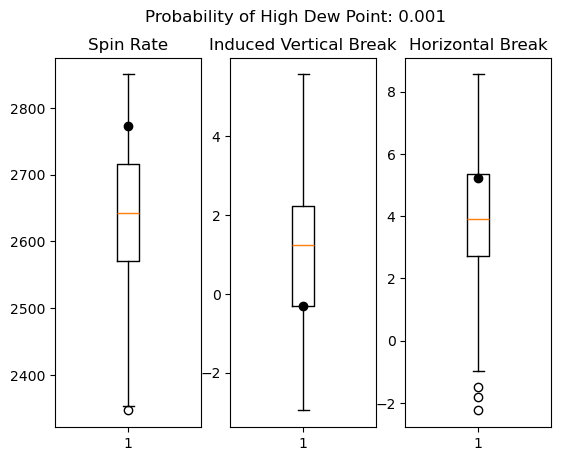

In [9]:
# chooses a random pitch (with dew point probability) and reindexes 
sample = probs_df.sample()
sample.index = [0]

# gets the pitch statistics for that pitch
sample_stats = df.loc[df['PID']==sample.loc[0, 'PID'], :]
sample_stats.index = [0]

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

# plots box plots for spin rate, vertical break, and horizontal break of all pitches by the same pitcher and pitch type as the sampled pitch
ax1.boxplot(df.loc[(df['PITCHER_KEY']==sample_stats.loc[0, 'PITCHER_KEY']) & (df['PITCH_TYPE_TRACKED_KEY']==sample_stats.loc[0, 'PITCH_TYPE_TRACKED_KEY']), 'SPIN_RATE_ABSOLUTE'])
ax2.boxplot(df.loc[(df['PITCHER_KEY']==sample_stats.loc[0, 'PITCHER_KEY']) & (df['PITCH_TYPE_TRACKED_KEY']==sample_stats.loc[0, 'PITCH_TYPE_TRACKED_KEY']), 'INDUCED_VERTICAL_BREAK'])
ax3.boxplot(df.loc[(df['PITCHER_KEY']==sample_stats.loc[0, 'PITCHER_KEY']) & (df['PITCH_TYPE_TRACKED_KEY']==sample_stats.loc[0, 'PITCH_TYPE_TRACKED_KEY']), 'HORIZONTAL_BREAK'])

# overlays those box plots with a "scatter" (single point) that shows where in the distribution the sampled pitch lies
ax1.scatter(1, sample_stats.loc[0, 'SPIN_RATE_ABSOLUTE'], c='k', label='Q1')
ax2.scatter(1, sample_stats.loc[0, 'INDUCED_VERTICAL_BREAK'], c='k', label='Q1')
ax3.scatter(1, sample_stats.loc[0, 'HORIZONTAL_BREAK'], c='k', label='Q1')

# titles the three plots
ax1.set_title('Spin Rate')
ax2.set_title('Induced Vertical Break')
ax3.set_title('Horizontal Break')

# adds the probability of that pitch being affected by a high dew point in the title
fig.suptitle('Probability of High Dew Point: ' + str(round(sample.loc[0, 'DEWPOINT_AFFECTED'], 3)))